In [4]:
import random
import time
import os

from tqdm.notebook import tqdm

import cv2
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from IPython import display

from torchvision.transforms import transforms
import torch.utils.data
from torchsummary import summary

import matplotlib.pyplot as plt
import itertools

from Recycle-GAN.models import networks as offnets
from pytorchCycleGANandpix2pix.models import cycle_gan_model as cg
from pytorchCycleGANandpix2pix.util.image_pool import ImagePool
from pytorchCycleGANandpix2pix.util.util import tensor2im

import cyclegan_models

SyntaxError: invalid syntax (952030250.py, line 25)

In [14]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

def revert_normalisation_batch(tensors):
    return (tensors.permute(0, 2, 3, 1) + 1) / 2

In [15]:
device = "cuda"

In [103]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
from torch.optim import lr_scheduler
import numpy as np
###############################################################################
# Functions
###############################################################################


def weights_init_normal(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal(m.weight.data, gain=0.02)
    elif classname.find('Linear') != -1:
        init.xavier_normal(m.weight.data, gain=0.02)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal(m.weight.data, gain=1)
    elif classname.find('BatchNorm2d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def define_G(input_nc, output_nc, ngf, which_model_netG, norm='batch', use_dropout=False, init_type='normal', gpu_ids=[], special_up=False):
    netG = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert(torch.cuda.is_available())

    if which_model_netG == 'resnet_9blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9, gpu_ids=gpu_ids)
    elif which_model_netG == 'resnet_6blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6, gpu_ids=gpu_ids, special_up=special_up)
    elif which_model_netG == 'unet_128':
        netG = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout, gpu_ids=gpu_ids)
    elif which_model_netG == 'unet_256':
        netG = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout, gpu_ids=gpu_ids)
    elif which_model_netG == 'prediction':
        netG = PredictionNViews(input_nc, output_nc, 6, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % which_model_netG)
    if len(gpu_ids) > 0:
        netG.cuda(gpu_ids[0])
    init_weights(netG, init_type=init_type)
    return netG


def define_D(input_nc, ndf, which_model_netD,
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', gpu_ids=[]):
    netD = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert(torch.cuda.is_available())
    if which_model_netD == 'basic':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid, gpu_ids=gpu_ids)
    elif which_model_netD == 'n_layers':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid, gpu_ids=gpu_ids)
    elif which_model_netD == 'pixel':
        netD = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer, use_sigmoid=use_sigmoid, gpu_ids=gpu_ids)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' %
                                  which_model_netD)
    if use_gpu:
        netD.cuda(gpu_ids[0])
    init_weights(netD, init_type=init_type)
    return netD


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)


##############################################################################
# Classes
##############################################################################


# Defines the GAN loss which uses either LSGAN or the regular GAN.
# When LSGAN is used, it is basically same as MSELoss,
# but it abstracts away the need to create the target label tensor
# that has the same size as the input
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, gpu_ids=[], padding_type='reflect', special_up=False):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        
        if not special_up:
            for i in range(n_downsampling):
                mult = 2**(n_downsampling - i)
                model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1,
                                             bias=use_bias),
                          norm_layer(int(ngf * mult / 2)),
                          nn.ReLU(True)]
        else:
            for i in range(n_downsampling):
                mult = 2**(n_downsampling - i)
                model += [nn.Upsample(scale_factor = 2, mode='bilinear'),
                          nn.ReflectionPad2d(1),
                          nn.Conv2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=1, padding=0),
                          norm_layer(int(ngf * mult / 2)),
                          nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

# ----------------------------------------------------------------------------------------------------
# Prediction Model (2Views) --
# PredictionNViews(input_nc, output_nc, 6, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
# ---------------------------------------------------------------------------------------------------

class PredictionNViews(nn.Module):
    def __init__(self, input_nc, output_nc,num_downs,  ngf=32,  norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6):
        assert(n_blocks >= 0)
        super(PredictionNViews, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        #self.gpu_ids = gpu_ids

        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model1 = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        model1 += [nn.Conv2d(ngf, ngf*2, kernel_size=3,
                              stride=1, padding=1, bias=use_bias),
                      norm_layer(ngf*2),
                      nn.ReLU(True)]
        model1 += [nn.Conv2d(ngf*2, ngf*4, kernel_size=3,
                              stride=1, padding=1, bias=use_bias),
                      norm_layer(ngf*4),
                      nn.ReLU(True)]

        # feed this data to a U-Net generator
        model = UnetGenerator(ngf*4*2, ngf*4, num_downs, ngf*4*4, norm_layer=norm_layer, use_dropout=use_dropout)
        #unet_block = UnetSkipConnectionBlock(ngf*mult*4, , input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)

        model3 = [nn.Conv2d(ngf * 4, ngf * 2, kernel_size=3,
                               stride=1, padding=1, bias=use_bias),
                      norm_layer(ngf * 2),
                      nn.ReLU(True)]
        model3 += [nn.Conv2d(ngf * 2, ngf, kernel_size=3,
                               stride=1, padding=1, bias=use_bias),
                      norm_layer(ngf),
                      nn.ReLU(True)]
        model3 += [nn.ReflectionPad2d(3)]
        model3 += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model3 += [nn.Tanh()]

        self.model = model
        self.model1 = nn.Sequential(*model1)
        self.model3 = nn.Sequential(*model3)

    def forward(self, input0, input1):
        f0 = self.model1(input0)
        f1 = self.model1(input1)

        g =  self.model(torch.cat((f0,f1),1))
        return self.model3(g)

# ----------------------------------------


# Defines the Unet generator.
# |num_downs|: number of downsamplings in UNet. For example,
# if |num_downs| == 7, image of size 128x128 will become of size 1x1
# at the bottleneck
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False, gpu_ids=[]):
        super(UnetGenerator, self).__init__()
        self.gpu_ids = gpu_ids

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)

class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(PixelDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
            
        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.net, input, self.gpu_ids)
        else:
            return self.net(input)



In [195]:
model = define_G(input_nc=3, output_nc=3, ngf=64, which_model_netG="resnet_6blocks", norm="instance", use_dropout=False, gpu_ids=[], special_up=True)
#offnets.ResnetGenerator(3, 3, 64, norm_layer=get_norm_layer("instance"), use_dropout=False, n_blocks=9)

from collections import OrderedDict
m_35 = "./Recycle-GAN/checkpoints/movie_game_test_improved_with_idt_no_convtranspose_1/35_net_G_A.pth"
m_70 = "./Recycle-GAN/checkpoints/movie_game_test_improved_with_idt_no_convtranspose_1/70_net_G_A.pth"
m_latest = "./Recycle-GAN/checkpoints/movie_game_test_improved_with_idt_no_convtranspose_1/latest_net_G_A.pth"
model_dict = torch.load(m_35)
# new_dict = OrderedDict()
# for k, v in model_dict.items():
#     # load_state_dict expects keys with prefix 'module.'
#     new_dict["module.model." + '.'.join(k.split(".")[1:])] = v

# own = model.state_dict()
# for name, param in new_dict.items():
#     if name not in own:
#         continue
#     model.state_dict()[name].copy_(param)

model.load_state_dict(model_dict)



# "./pytorchCycleGANandpix2pix/checkpoints/off_cyc_494/200_net_G_A.pth"
model.to(device)
model.eval()
;

initialization method [normal]


C:\Users\yoyo1\AppData\Local\Temp\ipykernel_13996\16811032.py:17: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, 0.0, 0.02)


''

In [196]:
dist_test_image_loc = "./selected_data/experiment_stratified_selection_1678204517.945494_cyclegan_off/testB/half_body_0.jpg"
non_dist_test_image_loc = "./examples/non_dist_horse.jpg"

In [197]:
dist_test_image = cv2.cvtColor(cv2.imread(dist_test_image_loc), cv2.COLOR_BGR2RGB)
non_dist_test_image = cv2.cvtColor(cv2.imread(non_dist_test_image_loc), cv2.COLOR_BGR2RGB)

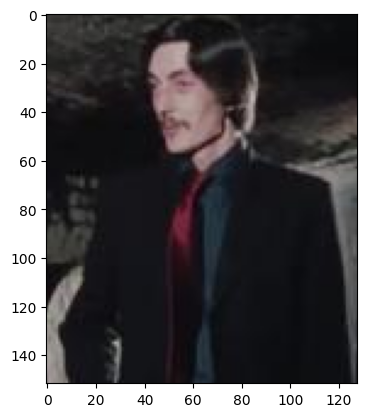

In [198]:
plt.imshow(dist_test_image)

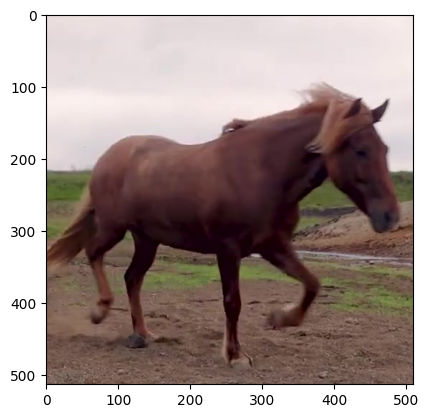

In [199]:
plt.imshow(non_dist_test_image)

In [200]:
preprocess_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [201]:
def revert_normalisation(tensor):
    return (tensor.permute(1, 2, 0) + 1) / 2

In [202]:
dist_test_tensor = preprocess_transform(dist_test_image).unsqueeze(0).to(device)
non_dist_test_tensor = preprocess_transform(non_dist_test_image).unsqueeze(0).to(device)

In [203]:
with torch.no_grad():
    dist_transferred = model(dist_test_tensor)
    non_dist_transferred = model(non_dist_test_tensor)

In [204]:
dist_transferred_img = revert_normalisation(dist_transferred.squeeze().cpu())
non_dist_transferred_img = revert_normalisation(non_dist_transferred.squeeze().cpu())

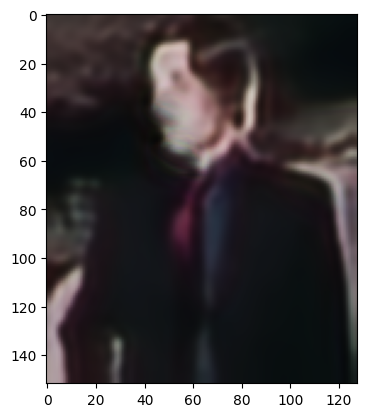

In [205]:
plt.imshow(dist_transferred_img)

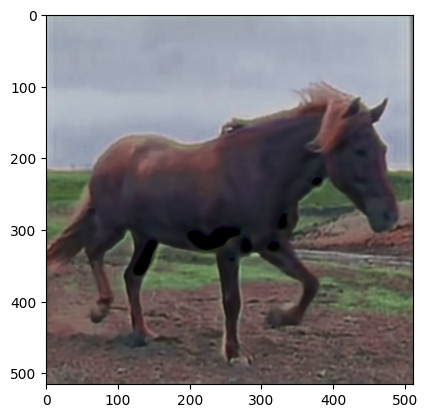

In [206]:
plt.imshow(non_dist_transferred_img)

In [207]:
def transfer_style_to_batch(cv2_images):
    imgs = [preprocess_transform(img) for img in cv2_images]
    imgs = torch.stack(imgs).to(device)
    
    with torch.no_grad():
        imgs_transferred = model(imgs)
    
    imgs_transferred = [revert_normalisation(img_t.cpu()) for img_t in imgs_transferred]
    return imgs_transferred

In [208]:
frame_locs = [
    "./frames/Test/Test_Test Movie_00056.jpg",
    "./frames/Test/Test_Test Movie_00199.jpg"
]

In [209]:
loaded_frames = [cv2.cvtColor(cv2.imread(frame_loc), cv2.COLOR_BGR2RGB) for frame_loc in frame_locs]

In [210]:
transferred_frames = transfer_style_to_batch(loaded_frames)

In [190]:
for i, frame in enumerate(transferred_frames):
    cv2.imwrite(f"./examples/off_35_rec_cyc_494_000{i}_t.jpg", cv2.cvtColor(frame.numpy() * 255, cv2.COLOR_RGB2BGR))

In [211]:
video_in_loc = "./data/Test/Test Movie.mp4"
video_out_loc = "./examples/transfered_off_recycle_35.mp4"
batch_size = 4

In [212]:
video_in = cv2.VideoCapture(video_in_loc)

In [213]:
def process_video(video, save_loc):
    # Try to delete the existing saved file
    try:
        os.remove(save_loc)
    except OSError:
        pass 
    
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    success, frame = video.read()
    height, width, _ = frame.shape
    
    frame_buffer = []
    video_out = cv2.VideoWriter(save_loc, -1, fps, (width, height))
    
    with tqdm(total=total_frames) as progress:
        while success:
            frame_buffer.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            if len(frame_buffer) == batch_size:
                transferred_frames = transfer_style_to_batch(frame_buffer)

                for out_frame in transferred_frames:
                    coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
                    video_out.write(coloured_out_frame)

                frame_buffer = []

            success, frame = video.read()
            progress.update(1)
    
    if len(frame_buffer) != 0:
        # Process any additional final frames that don't make a full batch
        transferred_frames = transfer_style_to_batch(frame_buffer)

        for out_frame in transferred_frames:
            coloured_out_frame = cv2.cvtColor((out_frame.numpy() * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            video_out.write(coloured_out_frame)
    
    video_out.release()

In [214]:
process_video(video_in, video_out_loc)

  0%|          | 0/1645 [00:00<?, ?it/s]